# HATE SPEECH IDENTIFICATION

## Problem Statement
The problem is to develop a machine learning model that can accurately classify tweets into one of three categories: 
- hate speech
- offensive language
- neither, 

based on the judgments of CrowdFlower users. This model will be trained using the provided dataset and then used to predict the class labels for new, unseen tweets.

#### Data Description

- count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).
- hate_speech = number of CF users who judged the tweet to be hate speech.
- offensive_language = number of CF users who judged the tweet to be offensive.
- neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.
- class = class label for majority of CF users.
0 - hate speech
1 - offensive  language
2 - neither
- tweet = raw tweet text

#### Importing necessary libraries

In [73]:
# General Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing libraries
import re
import string
import emoji
import unicodedata
import nltk
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize, WordPunctTokenizer, TweetTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer, SnowballStemmer
from textblob import TextBlob

# Consistent sized plot 
from pylab import rcParams
rcParams['figure.figsize']=12,5
rcParams['axes.labelsize']=12
rcParams['xtick.labelsize']=12
rcParams['ytick.labelsize']=12
from wordcloud import WordCloud

# Handle the warnings
import warnings
warnings.filterwarnings(action='ignore',category=DeprecationWarning)
warnings.filterwarnings(action='ignore',category=FutureWarning)

#display pandas dataframe columns 
pd.options.display.max_columns = None

# Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from langdetect import detect, LangDetectException
from collections import Counter
import contractions
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.models import Word2Vec
from gensim.models import LdaModel
from gensim.corpora import Dictionary

# Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
#from xgboost import xgboost

# PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec

# Transformers library for BERT
import transformers
from transformers import BertModel
from transformers import BertTokenizer
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import classification_report, confusion_matrix

import time

# Set seed for reproducibility
import random
seed_value = 2042
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

# Set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

# Define stop words for text cleaning
stop_words = set(stopwords.words('english'))

# Initialize lemmatizer for text cleaning
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to C:\Users\Al
[nltk_data]     rho\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to C:\Users\Al
[nltk_data]     rho\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Al
[nltk_data]     rho\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Al
[nltk_data]     rho\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


<Figure size 1200x500 with 0 Axes>

#### Data Preprocessing

In [74]:
# Load the dataset
df = pd.read_csv('./data/labeled_data.csv', encoding='utf-8', delimiter=',')

In [75]:
df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [76]:
df.describe()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,12681.192027,3.243473,0.280515,2.413711,0.549247,1.110277
std,7299.553863,0.883060,0.631851,1.399459,1.113299,0.462089
min,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,6372.500000,3.000000,0.000000,2.000000,0.000000,1.000000
50%,12703.000000,3.000000,0.000000,3.000000,0.000000,1.000000
75%,18995.500000,3.000000,0.000000,3.000000,0.000000,1.000000
max,25296.000000,9.000000,7.000000,9.000000,9.000000,2.000000


In [77]:
df.shape

(24783, 7)

In [78]:
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


##### Tweet cleaning

In [79]:
df.isna().sum()

count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [80]:
# Remove user handles
def remove_handles(text):
    return re.sub(r'@\w+', '', text)

In [81]:
df['tweet'] = df['tweet'].apply(remove_handles)

In [82]:
# Remove accents and simplify tweet
def simplify(text):
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode('utf-8')
    return text

In [83]:
df['tweet'] = df['tweet'].apply(simplify)

In [84]:
# Remove hashtags
def remove_hashtags(text):
    clean_text = re.sub(r'#', '', text)
    return clean_text

# Remove multiple spaces
def remove_spaces(text):
    return re.sub(r"\s\s+", " ", text)

# Expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Convert emojis to text
def emoji_to_texts(text):
    return emoji.demojize(text)

In [85]:
df['tweet'] = df['tweet'].apply(remove_hashtags).apply(remove_spaces).apply(expand_contractions).apply(emoji_to_texts)

In [86]:
# Remove stopwords
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    custom_stopwords = ["I", "rt", "RT"]
    stop_words.update(custom_stopwords)
    word_tokens = word_tokenize(text)
    return " ".join([word
                     for word in word_tokens if word not in stop_words])
    
# Remove special characters like '$' and '&' from sentences
def remove_chars(text):
     return ' '.join(word.replace('$', '').replace('&', '') for word in text.split())

# Remove digits
def remove_digits(text):
    return re.sub(r'\d+', '', text)

In [87]:
df['tweet'] = df['tweet'].apply(remove_stopwords).apply(remove_chars).apply(remove_digits)

In [88]:
# Corrections to spellings
def corrections(text):
    return TextBlob(text).correct()

# Remove repeated punctuation
def remove_multiple_puncts(text):
    pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
    return pattern.sub('', text)

# Remove urls
def remove_urls(text):
    url_pattern = re.compile(r'http[s]?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [89]:
df['tweet'] = df['tweet'].apply(remove_multiple_puncts).apply(remove_urls)

In [90]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    words = word_tokenize(text)
    words = [stemmer.stem(lemmatizer.lemmatize(word)) for word in words if word not in stop_words]
    return ' '.join(words)

df['tweet'] = df['tweet'].apply(preprocess_text)

In [91]:
# Using Tweet Tokenizer
tknzr = TweetTokenizer()
def tokenize_tweet(text):
    return tknzr.tokenize(text)

In [92]:
df['tweet'] = df['tweet'].apply(tokenize_tweet)

In [93]:
df.head(20)

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,"[as, woman, complain, clean, hous, amp, man, a..."
1,3,0,3,0,1,"[boy, dat, cold, tyga, dwn, bad, cuffin, dat, ..."
2,3,0,3,0,1,"[dawg, you, ever, fuck, bitch, start, cri, you..."
3,3,0,2,1,1,"[look, like, tranni]"
4,6,0,6,0,1,"[the, shit, hear, might, true, might, faker, b..."
5,3,1,2,0,1,"[the, shit, blow, claim, faith, somebodi, stil..."
6,3,0,3,0,1,"[sit, hate, anoth, bitch, got, much, shit, go]"
7,3,0,3,0,1,"[tire, big, bitch, come, u, skinni, girl]"
8,3,0,3,0,1,"[amp, might, get, ya, bitch, back, amp]"
9,3,1,2,0,1,"[hobbi, includ, fight, mariam, bitch]"


#### Exploratory Data Analysis

<Axes: >

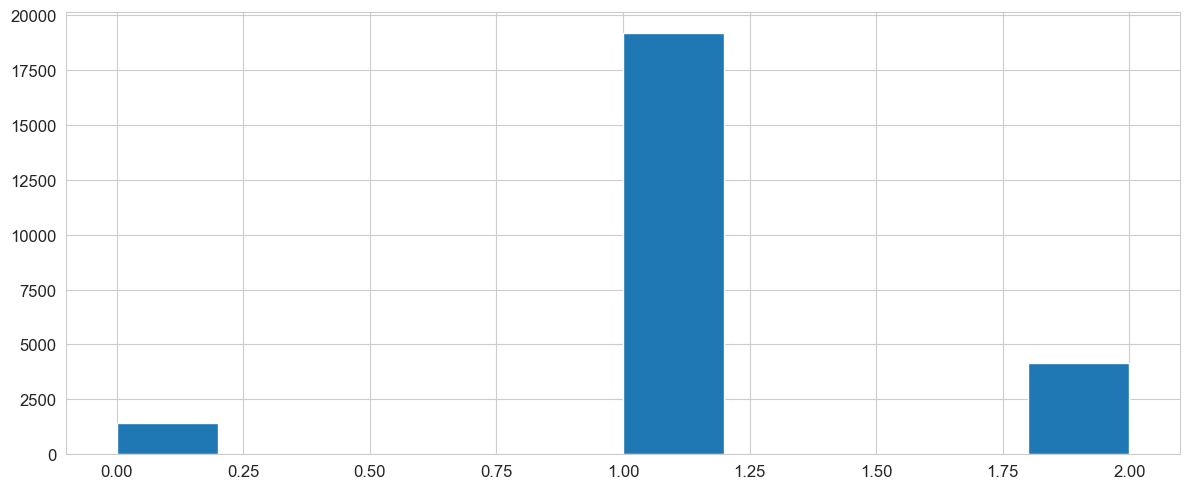

In [94]:
df['class'].hist()

The classes are imbalanced with offensive language having the most inputs from users. This can be balanced by using one of many methods such as Undersampling, Oversampling, SMOTE etc.

In [95]:
df['tweet_length'] = [len(tweet) for tweet in df['tweet']]
df.head()

,count,hate_speech,offensive_language,neither,class,tweet,tweet_length
0,3,0,0,3,2,"[as, woman, complain, clean, hous, amp, man, a...",10
1,3,0,3,0,1,"[boy, dat, cold, tyga, dwn, bad, cuffin, dat, ...",11
2,3,0,3,0,1,"[dawg, you, ever, fuck, bitch, start, cri, you...",10
3,3,0,2,1,1,"[look, like, tranni]",3
4,6,0,6,0,1,"[the, shit, hear, might, true, might, faker, b...",10


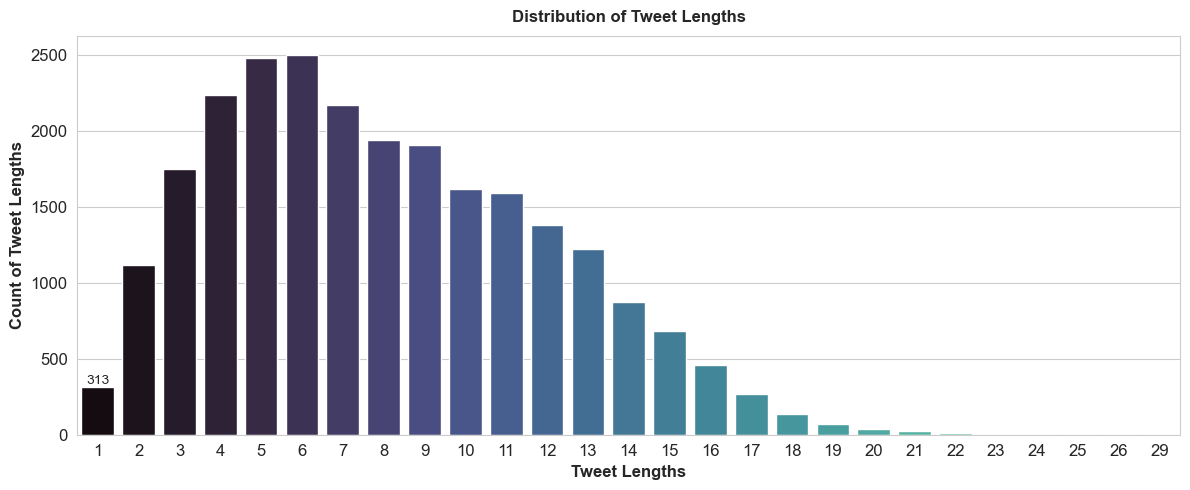

In [96]:
# Distribution of Tweet length
ax = sns.countplot(x='tweet_length', data=df[df['tweet_length']>0], palette='mako')
ax.bar_label(ax.containers[0])
plt.title('Distribution of Tweet Lengths')
plt.ylabel('Count of Tweet Lengths')
plt.xlabel('Tweet Lengths')
plt.show()

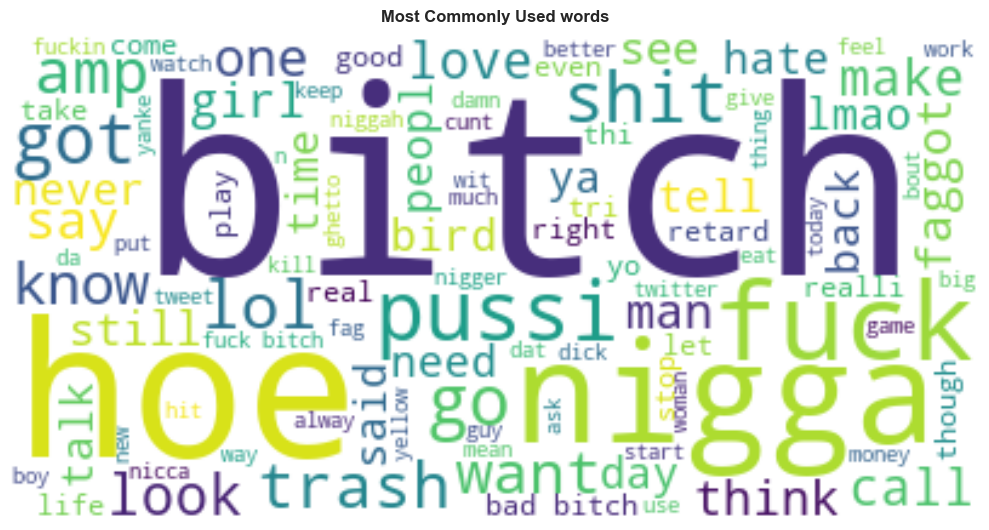

In [97]:
tweets = ' '.join([' '.join(tweet) if isinstance(tweet, list) else tweet for tweet in df['tweet']])
wordcloud = WordCloud(background_color="white", max_words=100)
wordcloud.generate(tweets)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Most Commonly Used words')
plt.axis("off")
plt.show()

In [98]:
categories = df['class'].unique()

for cat in categories:
    df_class = df[df['class'] == cat]
    words = [word for tweet in df_class['tweet'] for word in tweet]
    common = Counter(words).most_common(10)

    print(f"Class: {cat}")
    print(f"Most Common Words In {cat}: {common}")
    print("\n")

Class: 2
Most Common Words In 2: [('http', 1021), ('trash', 698), ('bird', 467), ('like', 316), ('yanke', 282), ('charli', 262), ('yellow', 219), ('get', 218), ('the', 205), ('go', 200)]


Class: 1
Most Common Words In 1: [('bitch', 11160), ('hoe', 4185), ('like', 2375), ('pussi', 2190), ('fuck', 2043), ('http', 1977), ('nigga', 1788), ('get', 1483), ('as', 1437), ('got', 1420)]


Class: 0
Most Common Words In 0: [('bitch', 267), ('faggot', 252), ('fuck', 222), ('nigga', 215), ('like', 176), ('nigger', 169), ('as', 144), ('http', 129), ('white', 128), ('trash', 114)]




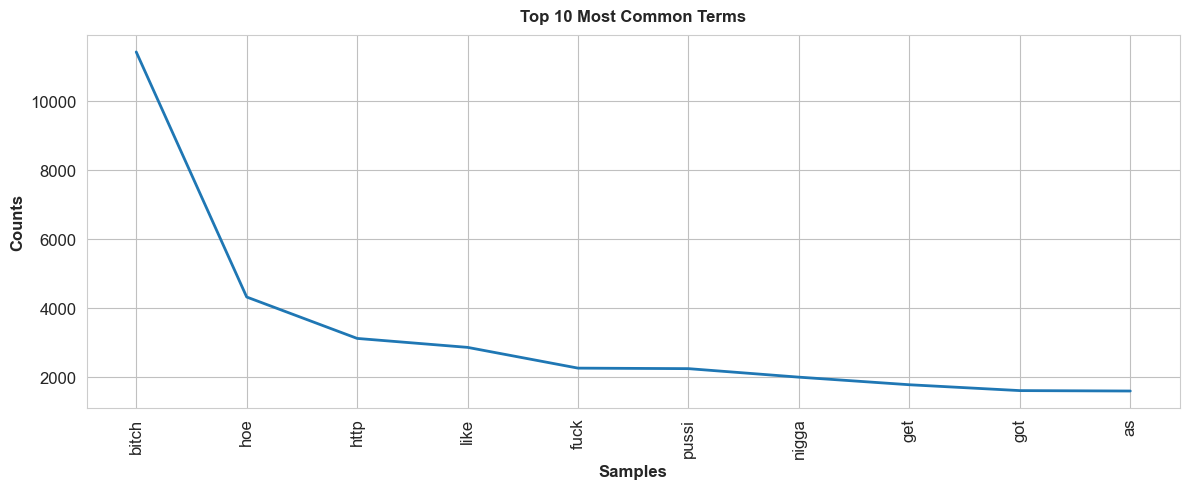

In [99]:
count = Counter()
tweets = [' '.join(tweet) if isinstance(tweet, list) else tweet for tweet in df['tweet']]
for tweet in tweets:
    count.update(tweet.split())

#Plot the frequency of the top 10 most common tokens 
frequency = nltk.FreqDist(count)
plt.title('Top 10 Most Common Terms')
frequency.plot(10,cumulative=False)
plt.show()

#### Feature Engineering

In [100]:
df['class'].value_counts()

class
1    19190
2     4163
0     1430
Name: count, dtype: int64

In [101]:
# Join the tokens back to get the tweets
df['tweet'] = df['tweet'].apply(lambda x: ' '.join(x))

In [102]:
df.head()

,count,hate_speech,offensive_language,neither,class,tweet,tweet_length
0,3,0,0,3,2,as woman complain clean hous amp man alway tak...,10
1,3,0,3,0,1,boy dat cold tyga dwn bad cuffin dat hoe st place,11
2,3,0,3,0,1,dawg you ever fuck bitch start cri you confus ...,10
3,3,0,2,1,1,look like tranni,3
4,6,0,6,0,1,the shit hear might true might faker bitch tol...,10


In [103]:
# Sentiment Analysis
sia = SentimentIntensityAnalyzer()
df['sentiment'] = df['tweet'].apply(lambda tweet: sia.polarity_scores(tweet))

# Word Embeddings
tweets = [tweet.split() for tweet in df['tweet']]
word2vec = Word2Vec(tweets, min_count=2)
def get_word_vectors(tweet):
    return [word2vec.wv[word] for word in tweet.split() if word in word2vec.wv.key_to_index]

df['word2vec'] = df['tweet'].apply(get_word_vectors)

# Topic Modeling
dictionary = Dictionary(tweets)
corpus = [dictionary.doc2bow(tweet) for tweet in tweets]
lda = LdaModel(corpus, num_topics=10)
df['lda'] = df['tweet'].apply(lambda tweet: lda[dictionary.doc2bow(tweet.split())])

In [104]:
df.head()

,count,hate_speech,offensive_language,neither,class,tweet,tweet_length,sentiment,word2vec,lda
0,3,0,0,3,2,as woman complain clean hous amp man alway tak...,10,"{'neg': 0.189, 'neu': 0.606, 'pos': 0.205, 'co...","[[-0.329968, 0.5096382, 0.15365705, 0.16123186...","[(6, 0.6456058), (9, 0.28165168)]"
1,3,0,3,0,1,boy dat cold tyga dwn bad cuffin dat hoe st place,11,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'comp...","[[-0.3356608, 0.50479597, 0.26059538, 0.171206...","[(4, 0.9223056)]"
2,3,0,3,0,1,dawg you ever fuck bitch start cri you confus ...,10,"{'neg': 0.609, 'neu': 0.391, 'pos': 0.0, 'comp...","[[-0.13177675, 0.21596734, 0.1065305, 0.072071...","[(1, 0.11124699), (5, 0.6934422), (8, 0.131656..."
3,3,0,2,1,1,look like tranni,3,"{'neg': 0.0, 'neu': 0.444, 'pos': 0.556, 'comp...","[[-0.30000332, 0.5389098, 0.24627662, 0.227597...","[(0, 0.025002455), (1, 0.2933279), (2, 0.02500..."
4,6,0,6,0,1,the shit hear might true might faker bitch tol...,10,"{'neg': 0.43, 'neu': 0.407, 'pos': 0.163, 'com...","[[-0.28560495, 0.50671893, 0.3490749, 0.141742...","[(1, 0.21707943), (8, 0.70987207)]"


In [105]:
# Split sentiment into separate columns
df[['neg_sentiment', 'neu_sentiment', 'pos_sentiment', 'compound']] = df['sentiment'].apply(pd.Series)

# Take the mean of the lists for word2vec and lda
df['word2vec_mean'] = df['word2vec'].apply(lambda x: np.mean(x) if isinstance(x, list) else np.nan)
df['lda_mean'] = df['lda'].apply(lambda x: np.mean(x) if isinstance(x, list) else np.nan)

C:\Users\Al rho\AppData\Roaming\Python\Python311\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\Al rho\AppData\Roaming\Python\Python311\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [106]:
df.head()

,count,hate_speech,offensive_language,neither,class,tweet,tweet_length,sentiment,word2vec,lda,neg_sentiment,neu_sentiment,pos_sentiment,compound,word2vec_mean,lda_mean
0,3,0,0,3,2,as woman complain clean hous amp man alway tak...,10,"{'neg': 0.189, 'neu': 0.606, 'pos': 0.205, 'co...","[[-0.329968, 0.5096382, 0.15365705, 0.16123186...","[(6, 0.6456058), (9, 0.28165168)]",0.189,0.606,0.205,0.0516,0.005747,3.981814
1,3,0,3,0,1,boy dat cold tyga dwn bad cuffin dat hoe st place,11,"{'neg': 0.259, 'neu': 0.741, 'pos': 0.0, 'comp...","[[-0.3356608, 0.50479597, 0.26059538, 0.171206...","[(4, 0.9223056)]",0.259,0.741,0.000,-0.5423,0.005095,2.461153
2,3,0,3,0,1,dawg you ever fuck bitch start cri you confus ...,10,"{'neg': 0.609, 'neu': 0.391, 'pos': 0.0, 'comp...","[[-0.13177675, 0.21596734, 0.1065305, 0.072071...","[(1, 0.11124699), (5, 0.6934422), (8, 0.131656...",0.609,0.391,0.000,-0.8979,0.007310,2.489391
3,3,0,2,1,1,look like tranni,3,"{'neg': 0.0, 'neu': 0.444, 'pos': 0.556, 'comp...","[[-0.30000332, 0.5389098, 0.24627662, 0.227597...","[(0, 0.025002455), (1, 0.2933279), (2, 0.02500...",0.000,0.444,0.556,0.3612,0.010332,2.300000
4,6,0,6,0,1,the shit hear might true might faker bitch tol...,10,"{'neg': 0.43, 'neu': 0.407, 'pos': 0.163, 'com...","[[-0.28560495, 0.50671893, 0.3490749, 0.141742...","[(1, 0.21707943), (8, 0.70987207)]",0.430,0.407,0.163,-0.6808,0.004229,2.481738


In [107]:
df = df.drop(['sentiment', 'word2vec', 'lda'], axis=1)
df.head()

,count,hate_speech,offensive_language,neither,class,tweet,tweet_length,neg_sentiment,neu_sentiment,pos_sentiment,compound,word2vec_mean,lda_mean
0,3,0,0,3,2,as woman complain clean hous amp man alway tak...,10,0.189,0.606,0.205,0.0516,0.005747,3.981814
1,3,0,3,0,1,boy dat cold tyga dwn bad cuffin dat hoe st place,11,0.259,0.741,0.000,-0.5423,0.005095,2.461153
2,3,0,3,0,1,dawg you ever fuck bitch start cri you confus ...,10,0.609,0.391,0.000,-0.8979,0.007310,2.489391
3,3,0,2,1,1,look like tranni,3,0.000,0.444,0.556,0.3612,0.010332,2.300000
4,6,0,6,0,1,the shit hear might true might faker bitch tol...,10,0.430,0.407,0.163,-0.6808,0.004229,2.481738


In [108]:
df['class'].value_counts()

class
1    19190
2     4163
0     1430
Name: count, dtype: int64

In [109]:
df['word2vec_mean'] = df['word2vec_mean'].fillna(0)
df.isna().sum()

count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
tweet_length          0
neg_sentiment         0
neu_sentiment         0
pos_sentiment         0
compound              0
word2vec_mean         0
lda_mean              0
dtype: int64

#### Modeling

##### Splitting the dataset

In [110]:
X = df[['tweet', 'tweet_length', 'neg_sentiment', 'neu_sentiment', 'pos_sentiment','compound', 'word2vec_mean', 'lda_mean']]
y = df['class']

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(19826, 8) (4957, 8) (19826,) (4957,)


- TF-IDF transformation is applied to associate weigths to the different words based on their frequency (rarer words will be given more importance).



In [112]:
vectorizer = TfidfVectorizer()
X_train_cv = vectorizer.fit_transform(X_train['tweet'])
X_test_cv = vectorizer.transform(X_test['tweet'])

In [113]:
from scipy.sparse import hstack

X_train_full = hstack((X_train_cv, X_train[['tweet_length', 'neg_sentiment', 'neu_sentiment', 'pos_sentiment','compound', 'word2vec_mean', 'lda_mean']].values))
X_test_full = hstack((X_test_cv, X_test[['tweet_length', 'neg_sentiment', 'neu_sentiment', 'pos_sentiment','compound', 'word2vec_mean', 'lda_mean']].values))

In [114]:
# Define the resampling strategy
over = SMOTE(sampling_strategy={0: 5000, 2: 5000})
under = RandomUnderSampler(sampling_strategy={1: 10000})

pipeline = Pipeline(steps=[('o', over), ('u', under)])
X_resampled, y_resampled = pipeline.fit_resample(X_train_full, y_train)

print(pd.Series(y_resampled).value_counts())

class
1    10000
0     5000
2     5000
Name: count, dtype: int64


##### Logistic Regression baseline model

In [115]:
# Logistic Regression
lr = LogisticRegression(random_state=42)
lr.fit(X_resampled, y_resampled)
y_pred_lr = lr.predict(X_test_full)
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       0.33      0.58      0.42       286
           1       0.94      0.87      0.91      3838
           2       0.78      0.85      0.81       833

    accuracy                           0.85      4957
   macro avg       0.69      0.77      0.71      4957
weighted avg       0.88      0.85      0.86      4957



c:\ProgramData\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


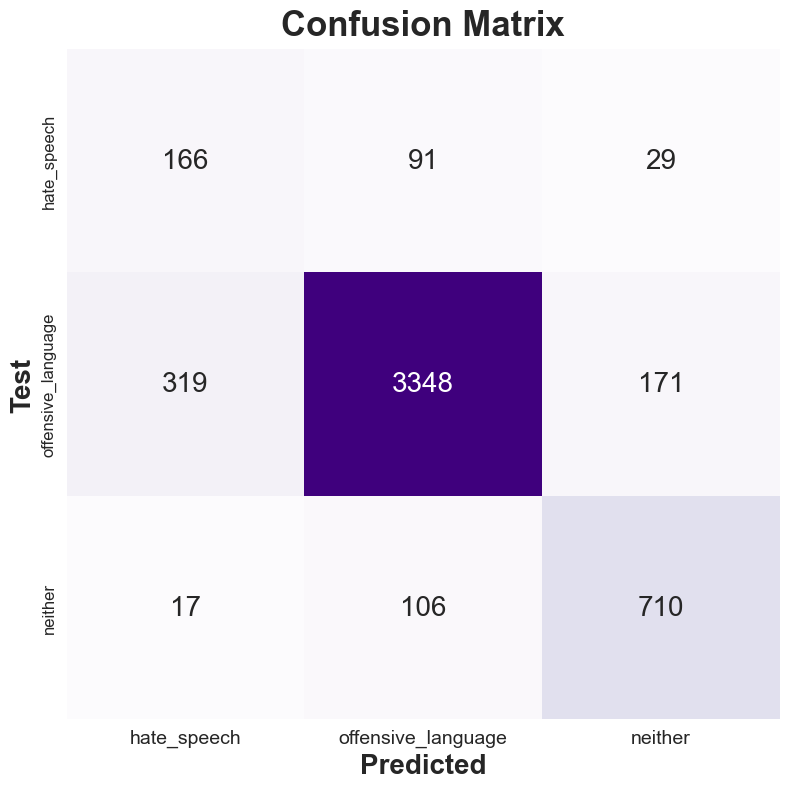

In [116]:
title = "Confusion Matrix"
labels = ['hate_speech', 'offensive_language', 'neither']  # replace with your actual labels

cm = confusion_matrix(y_test, y_pred_lr)
cm = cm.astype('float')

fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(cm, annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":20})
plt.title(title, fontsize=25)
ax.xaxis.set_ticklabels(labels, fontsize=14) 
ax.yaxis.set_ticklabels(labels, fontsize=12)
ax.set_ylabel('Test', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)
plt.show()

In [117]:
import pickle
pickle.dump(lr, open('lr.pkl', 'wb'))

In [118]:
gb = GradientBoostingClassifier()
gb.fit(X_resampled, y_resampled)

y_pred_gb = gb.predict(X_test_full)
print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.41      0.51      0.46       286
           1       0.95      0.91      0.93      3838
           2       0.79      0.90      0.84       833

    accuracy                           0.88      4957
   macro avg       0.72      0.77      0.74      4957
weighted avg       0.89      0.88      0.89      4957



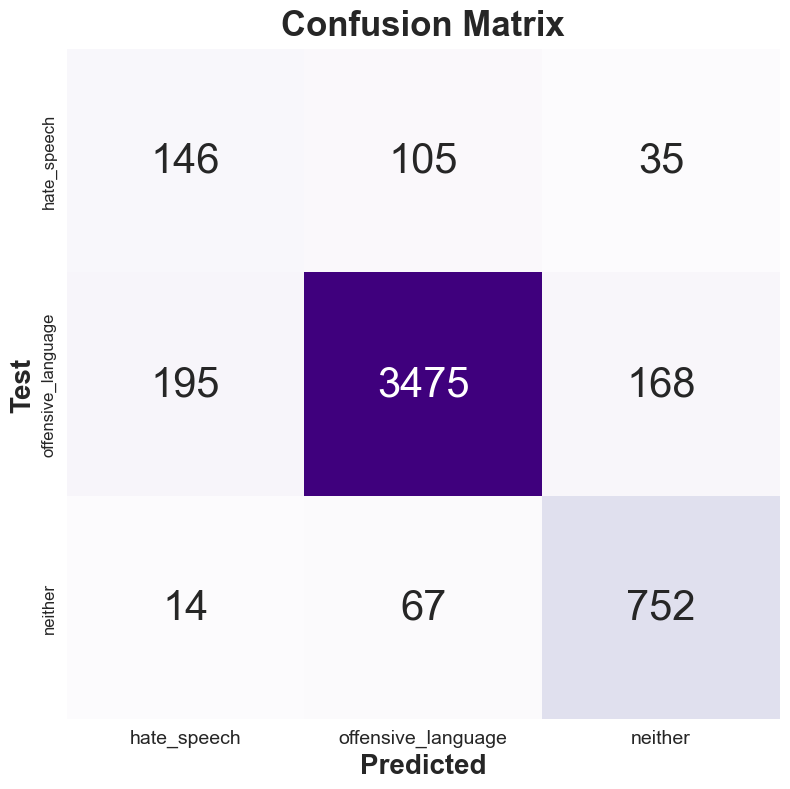

In [119]:
title = "Confusion Matrix"
labels = ['hate_speech', 'offensive_language', 'neither']  # replace with your actual labels

fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(confusion_matrix(y_test, y_pred_gb), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
plt.title(title, fontsize=25)
ax.xaxis.set_ticklabels(labels, fontsize=14) 
ax.yaxis.set_ticklabels(labels, fontsize=12)
ax.set_ylabel('Test', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)
plt.show()

In [120]:
pickle.dump(gb, open('gb.pkl', 'wb'))

##### Hyperparameter Tuning

In [121]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 4, 5],
    'criterion': ['friedman_mse', 'mse', 'mae']
}

gb = GradientBoostingClassifier()
random_search = RandomizedSearchCV(estimator=gb, param_distributions=param_grid, cv=5, n_iter=10, random_state=42)
random_search.fit(X_resampled, y_resampled)
print(random_search.best_params_)

# Evaluating the model with the best parameters using cross-validation
best_gb = random_search.best_estimator_
scores = cross_val_score(best_gb, X_resampled, y_resampled, cv=5, scoring='f1')

print(scores)
print(scores.mean())

#### PyTorch LSTM RNN
- In this section, we will define a custom Unidirectional and Bidirectional LSTM using PyTorch in order to perform the Sentiment Analysis on the tweets.

##### Data preprocessing for LSTM

In [ ]:
def Tokenize(column, seq_len):
    # Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    # Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    # Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [ ]:
max_len = np.max(df['tweet_length'])
vocab, tokenized = Tokenize(df["tweet"], max_len)

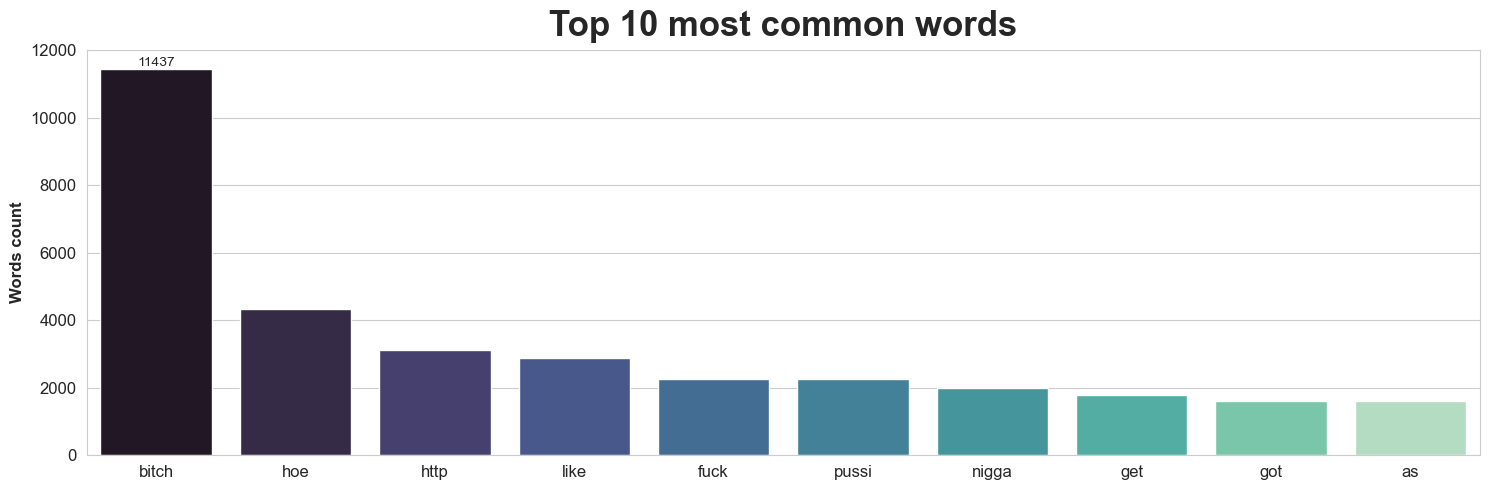

In [ ]:
# Check the top 10 most common words by extracting them from the vocabulary python dictionary created with the tokenizer.
keys = []
values = []
for key, value in vocab[:10]:
    keys.append(key)
    values.append(value)

plt.figure(figsize=(15, 5))
ax = sns.barplot(x=keys, y=values, palette='mako')
plt.title('Top 10 most common words', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()

##### Word Embedding by Word2Vec
- A word embedding matrix is created using the original text tweets and the pretrained model Word2Vec.


In [ ]:
x = df['tweet']
Y = df['class']

x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size=0.2, stratify=Y, random_state=seed_value)
print(x_train.shape,x_test.shape,Y_train.shape,Y_test.shape)

(19826,) (4957,) (19826,) (4957,)


In [ ]:
w2v_train = list(map(lambda x: x.split(), x_train))

EMBEDDING_DIM = 200
w2v_model = Word2Vec(w2v_train, vector_size=EMBEDDING_DIM)
print(f"Vocabulary size: {len(vocab)+1}")

Vocabulary size: 18988


In [ ]:
VOCAB_SIZE = len(vocab) + 1 
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))

for word, token in vocab:
    if word in w2v_model.wv.key_to_index:
        embedding_vector = w2v_model.wv[word]
        embedding_matrix[token] = embedding_vector

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (18988, 200)


In [ ]:
# Train - Validation - Test split

x = tokenized
Y = df['class'].values
x_train, x_test, Y_train, Y_test = train_test_split(x, Y, test_size=0.2, stratify=Y, random_state=seed_value)
x_train, x_valid, Y_train, Y_valid = train_test_split(x_train, Y_train, test_size=0.2, stratify=Y_train, random_state=seed_value)

In [ ]:
(unique, counts) = np.unique(Y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[    0,   915],
       [    1, 12281],
       [    2,  2664]], dtype=int64)

##### Resampling strategy
- The imbalanced classes are oversampled using SMOTE and the other class is undersampled using RandomUnderSampler. A pipeline is created to fit both methods

In [ ]:
over = SMOTE(sampling_strategy={0: 5000, 2: 5000})
under = RandomUnderSampler(sampling_strategy={1: 10000})

pipeline = Pipeline(steps=[('o', over), ('u', under)])
X_train_os, y_train_os = pipeline.fit_resample(x_train, Y_train)

print(pd.Series(y_train_os).value_counts())

1    10000
0     5000
2     5000
Name: count, dtype: int64


In [ ]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[    0,  5000],
       [    1, 10000],
       [    2,  5000]], dtype=int64)

In [ ]:
# The three sets will be transformed to tensor datasets and dataloaders so we can extract the data in batches for the LSTM training, validation and testing.

train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(x_test), torch.from_numpy(Y_test))
valid_data = TensorDataset(torch.from_numpy(x_valid), torch.from_numpy(Y_valid))

In [ ]:
BATCH_SIZE = 32
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=False, batch_size=BATCH_SIZE, drop_last=True)

##### PyTorch LSTM modeling

In [ ]:
class LSTM_Sentiment_Classifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, dropout, is_bidirectional):
        super(LSTM_Sentiment_Classifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = lstm_layers
        self.is_bidirectional = is_bidirectional

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, lstm_layers, batch_first=True, bidirectional=is_bidirectional)
        self.fc = nn.Linear(hidden_dim * (2 if is_bidirectional else 1), num_classes)
        self.softmax = nn.LogSoftmax()
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden):
        batch_size = x.size(0)
        embedded = self.embedding(x)
        out, hidden = self.lstm(embedded, hidden)
        out = out[:, -1, :]  
        out = self.dropout(out)
        out = self.fc(out)
        out = self.softmax(out)
        out = out.view(batch_size, -1)
        return out, hidden
        
    def init_hidden(self, batch_size):
        factor = 2 if self.is_bidirectional else 1
        h0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        c0 = torch.zeros(self.num_layers * factor, batch_size, self.hidden_dim).to(DEVICE)
        return h0, c0

In [ ]:
NUM_CLASSES = 3 
HIDDEN_DIM = 100
LSTM_LAYERS = 1

IS_BIDIRECTIONAL = False 
LR = 4e-4 
DROPOUT = 0.5 
EPOCHS = 10

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model = LSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_CLASSES, LSTM_LAYERS, DROPOUT, IS_BIDIRECTIONAL)
model = model.to(DEVICE)

# Initialize the embedding layer with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
model.embedding.weight.requires_grad = True

criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

print(model)

LSTM_Sentiment_Classifier(
  (embedding): Embedding(18988, 200)
  (lstm): LSTM(200, 100, batch_first=True)
  (fc): Linear(in_features=100, out_features=3, bias=True)
  (softmax): LogSoftmax(dim=None)
  (dropout): Dropout(p=0.5, inplace=False)
)


##### Training the LSTM Model

In [64]:
from sklearn.metrics import f1_score, accuracy_score

# Move the model to the device
model = model.to(DEVICE)

best_val_score = 0
patience = 3
no_improve_epoch = 0

for epoch in range(EPOCHS):
    model.train()  # Set the model to training mode
    total_loss = 0

    for batch in train_loader:
        input, targets = batch
        input = input.to(DEVICE)
        targets = targets.to(DEVICE)

        optimizer.zero_grad()
        # Perform forward pass
        output, _ = model(input, model.init_hidden(input.size(0)))
        
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.data.item()
    print("Epoch: {}, Training Loss: {}".format(epoch, total_loss / len(train_loader)))

    # Validation phase
    model.eval()  
    total_val_loss = 0
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in valid_loader:
            input, targets = batch
            input = input.to(DEVICE)
            targets = targets.to(DEVICE)

            output, _ = model(input, model.init_hidden(input.size(0)))
            loss = criterion(output, targets)
            total_val_loss += loss.data.item()

            # Store all predictions and targets for classification report
            preds = torch.argmax(output, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    val_accuracy = accuracy_score(all_targets, all_preds)
    val_f1 = f1_score(all_targets, all_preds, average='weighted')
    val_score = max(val_accuracy, val_f1)  
    print(f"Epoch: {epoch}, Validation Accuracy: {val_accuracy}, Validation F1-score: {val_f1}")

    # Early stopping and model saving
    if val_score > best_val_score:
        best_val_score = val_score
        torch.save(model.state_dict(), 'model.pth')
        no_improve_epoch = 0
    else:
        no_improve_epoch += 1
        if no_improve_epoch == patience:
            print("Early stopping")
            break

# Print classification report
print(classification_report(all_targets, all_preds))

c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 0, Training Loss: 0.8204630398273468
Epoch: 0, Validation Accuracy: 0.8147865853658537, Validation F1-score: 0.83880622849532


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 1, Training Loss: 0.6133228465080262
Epoch: 1, Validation Accuracy: 0.8480691056910569, Validation F1-score: 0.8623924716329587


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 2, Training Loss: 0.49004767558574674
Epoch: 2, Validation Accuracy: 0.8163109756097561, Validation F1-score: 0.8433280034047343


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 3, Training Loss: 0.3772887675523758
Epoch: 3, Validation Accuracy: 0.823170731707317, Validation F1-score: 0.8450860591102466


c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch: 4, Training Loss: 0.2935947651922703
Epoch: 4, Validation Accuracy: 0.7797256097560976, Validation F1-score: 0.8140811861881038
Early stopping
              precision    recall  f1-score   support

           0       0.17      0.48      0.25       226
           1       0.95      0.81      0.87      3047
           2       0.71      0.76      0.74       663

    accuracy                           0.78      3936
   macro avg       0.61      0.68      0.62      3936
weighted avg       0.87      0.78      0.81      3936



In [65]:
# Loading the best model
model.load_state_dict(torch.load('./model.pth'))

<All keys matched successfully>

In [66]:
# LSTM Testing
def evaluate_model(model, test_loader):
    model.eval()
    y_pred_list = []
    y_test_list = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            test_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, test_h)
            y_pred_test = torch.argmax(output, dim=1)
            y_pred_list.extend(y_pred_test.squeeze().tolist())
            y_test_list.extend(labels.squeeze().tolist())
    
    return y_pred_list, y_test_list

y_pred_list, y_test_list = evaluate_model(model, test_loader)

c:\ProgramData\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


In [67]:
print('Classification Report for Bi-LSTM :\n', classification_report(y_test_list, y_pred_list))

Classification Report for Bi-LSTM :
               precision    recall  f1-score   support

           0       0.25      0.41      0.31       284
           1       0.95      0.88      0.91      3816
           2       0.77      0.88      0.82       828

    accuracy                           0.85      4928
   macro avg       0.66      0.72      0.68      4928
weighted avg       0.88      0.85      0.86      4928



In [68]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test_list, y_pred_list)
print('Confusion Matrix for Bi-LSTM :\n', conf_mat)

Confusion Matrix for Bi-LSTM :
 [[ 117  123   44]
 [ 293 3354  169]
 [  62   39  727]]


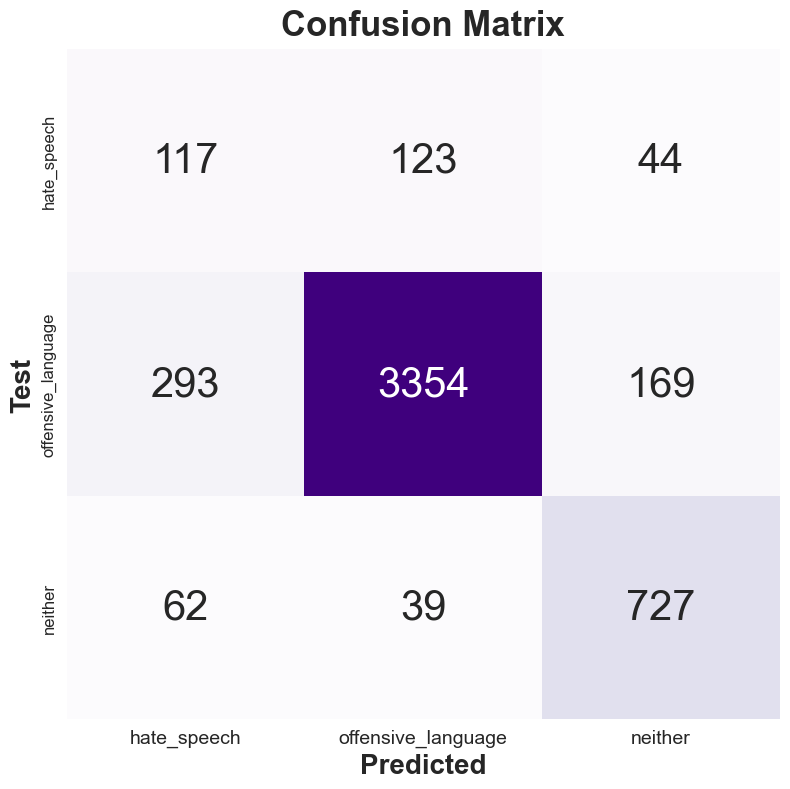

In [69]:
title = "Confusion Matrix"
labels = ['hate_speech', 'offensive_language', 'neither']  # replace with your actual labels

fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(confusion_matrix(y_test_list, y_pred_list), annot=True, cmap="Purples", fmt='g', cbar=False, annot_kws={"size":30})
plt.title(title, fontsize=25)
ax.xaxis.set_ticklabels(labels, fontsize=14) 
ax.yaxis.set_ticklabels(labels, fontsize=12)
ax.set_ylabel('Test', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)
plt.show()

##### Hyperparameter Tuning

In [ ]:
import optuna

def objective(trial):
    # Define hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    hidden_dim = trial.suggest_int('hidden_dim', 50, 200)
    lstm_layers = trial.suggest_int('lstm_layers', 1, 3)
    dropout = trial.suggest_uniform('dropout', 0.1, 0.5)
    is_bidirectional = trial.suggest_categorical('is_bidirectional', [True, False])

    # Create the model
    model = LSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, hidden_dim, NUM_CLASSES, lstm_layers, dropout, is_bidirectional, dim=1)
    model = model.to(DEVICE)

    # Initialize the embedding layer with the previously defined embedding matrix
    model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
    model.embedding.weight.requires_grad = True

    criterion = nn.NLLLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay = 5e-6)

    # Train and validate the model
    best_val_score = 0
    patience = 3
    no_improve_epoch = 0

    for epoch in range(EPOCHS):
        model.train()  # Set the model to training mode
        total_loss = 0

        for batch in train_loader:
            input, targets = batch
            input = input.to(DEVICE)
            targets = targets.to(DEVICE)

            optimizer.zero_grad()
            # Perform forward pass
            output, _ = model(input, model.init_hidden(input.size(0)))
            
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.data.item()

        # Validation phase
        model.eval()  
        total_val_loss = 0
        all_preds = []
        all_targets = []
        with torch.no_grad():
            for batch in valid_loader:
                input, targets = batch
                input = input.to(DEVICE)
                targets = targets.to(DEVICE)

                output, _ = model(input, model.init_hidden(input.size(0)))
                loss = criterion(output, targets)
                total_val_loss += loss.data.item()

                # Store all predictions and targets for classification report
                preds = torch.argmax(output, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

        val_accuracy = accuracy_score(all_targets, all_preds)
        val_f1 = f1_score(all_targets, all_preds, average='weighted')
        val_score = max(val_accuracy, val_f1)  

        # Early stopping and model saving
        if val_score > best_val_score:
            best_val_score = val_score
            no_improve_epoch = 0
        else:
            no_improve_epoch += 1
            if no_improve_epoch == patience:
                break

    return 1.0 - best_val_score  # Optuna minimizes the objective

study = optuna.create_study()
study.optimize(objective, n_trials=100)

In [ ]:
best_params = study.best_params
best_lr = best_params['lr']
best_lstm_layers = best_params['lstm_layers']
best_hidden_dim = best_params['hidden_dim']
best_dropout = best_params['dropout']
best_direction = best_params['is_bidirectional']

model = LSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, best_hidden_dim, NUM_CLASSES, best_lstm_layers, best_dropout, best_direction)
model = model.to(DEVICE)
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
model.embedding.weight.requires_grad = True
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=best_lr, weight_decay = 5e-6)

train_model(model, criterion, optimizer)

test_model(model, X_test_full, y_test_full)

In [ ]:
best_trial = study.best_trial
best_model = LSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, best_trial.params['hidden_dim'], NUM_CLASSES, best_trial.params['lstm_layers'], best_trial.params['dropout'], best_trial.params['is_bidirectional'])
best_model.load_state_dict(torch.load(f'model_{best_trial.number}.pth'))

In [ ]:
def test_model(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    total_correct = 0
    total_samples = 0
    with torch.no_grad():
        for batch in test_loader:
            input, targets = batch
            input = input.to(DEVICE)
            targets = targets.to(DEVICE)

            output, _ = model(input, model.init_hidden(input.size(0)))
            preds = torch.argmax(output, dim=1)

            total_correct += (preds == targets).sum().item()
            total_samples += targets.size(0)

    accuracy = total_correct / total_samples
    return accuracy

from torch.utils.data import TensorDataset, DataLoader

# Convert your test data into tensor
X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test)

# Create a TensorDataset from your test data
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Define a batch size
batch_size = 64

# Create a DataLoader from the TensorDataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Test the model
accuracy = test_model(model, test_loader)
print(f'Test accuracy: {accuracy * 100:.2f}%')